In [1]:
%matplotlib inline

## This project trains image classification model and also evaluate the trained model by confusion matrix

### This project train image classification model by reffering sample code from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html. 
### The dataset is from https://www.kaggle.com/pranavraikokte/covid19-image-dataset.


In [2]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
import cv2
from PIL import Image
from sklearn.metrics import confusion_matrix
from platform import python_version

from efficientnet_pytorch import EfficientNet
from torchsummary import summary

print("Python version : " + python_version())
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

Python version : 3.9.7
PyTorch Version:  1.10.1
Torchvision Version:  0.11.2


In [3]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir =  os.getcwd() + '/Covid19-dataset'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception, efficientnet]
model_name = "efficientnet"

# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for 
num_epochs = 30

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

# Optimizer to choose SGD or Adam
set_optimizer = 'SGD'

In [4]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_acc_epoch = 0
    

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs ))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_acc_epoch = epoch
                
                if feature_extract == True:
                    torch.save(model.state_dict(), model_name + '_'+ set_optimizer + "_pretrained.pth")    
                else:
                    torch.save(model.state_dict(), model_name + '_'+ set_optimizer + "_scratch.pth")


            if phase == 'val':
                val_acc_history.append(epoch_acc)
                
            if epoch == num_epochs - 1 and feature_extract == True:
                torch.save(model.state_dict(), model_name + '_'+ set_optimizer + '_pretrained_lastEpoch.pth')
            if epoch == num_epochs - 1 and feature_extract == False:
                torch.save(model.state_dict(), model_name + '_'+ set_optimizer + '_scratch_lastEpoch.pth')

        print()                         

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val Acc is from Epoch ' + str(best_acc_epoch +1))


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
        
    elif model_name == "efficientnet":

        """ efficientnet-b0
        """
    
        if feature_extract:
            model_ft = EfficientNet.from_pretrained('efficientnet-b0')
        else:
            model_ft = EfficientNet.from_name('efficientnet-b0')
          
        num_ftrs = model_ft._fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
            

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dS

Load Data
---------


In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(degrees=180),
        #transforms.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


Create the Optimizer
--------------------





In [8]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
if set_optimizer == 'SGD':
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
elif set_optimizer =='Adam':
    optimizer_ft = optim.Adam(params_to_update, lr=0.001, weight_decay=0.00001)
else:
    print("Invalid optimizer name, exiting...")
    exit()

Params to learn:
	 _conv_stem.weight
	 _bn0.weight
	 _bn0.bias
	 _blocks.0._depthwise_conv.weight
	 _blocks.0._bn1.weight
	 _blocks.0._bn1.bias
	 _blocks.0._se_reduce.weight
	 _blocks.0._se_reduce.bias
	 _blocks.0._se_expand.weight
	 _blocks.0._se_expand.bias
	 _blocks.0._project_conv.weight
	 _blocks.0._bn2.weight
	 _blocks.0._bn2.bias
	 _blocks.1._expand_conv.weight
	 _blocks.1._bn0.weight
	 _blocks.1._bn0.bias
	 _blocks.1._depthwise_conv.weight
	 _blocks.1._bn1.weight
	 _blocks.1._bn1.bias
	 _blocks.1._se_reduce.weight
	 _blocks.1._se_reduce.bias
	 _blocks.1._se_expand.weight
	 _blocks.1._se_expand.bias
	 _blocks.1._project_conv.weight
	 _blocks.1._bn2.weight
	 _blocks.1._bn2.bias
	 _blocks.2._expand_conv.weight
	 _blocks.2._bn0.weight
	 _blocks.2._bn0.bias
	 _blocks.2._depthwise_conv.weight
	 _blocks.2._bn1.weight
	 _blocks.2._bn1.bias
	 _blocks.2._se_reduce.weight
	 _blocks.2._se_reduce.bias
	 _blocks.2._se_expand.weight
	 _blocks.2._se_expand.bias
	 _blocks.2._project_conv.weight

Run Training and Validation Step
--------------------------------





In [9]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 1/30
----------
train Loss: 7.3059 Acc: 0.0000
val Loss: 8.8173 Acc: 0.0000

Epoch 2/30
----------
train Loss: 6.8265 Acc: 0.0040
val Loss: 8.1352 Acc: 0.0000

Epoch 3/30
----------
train Loss: 6.0741 Acc: 0.0444
val Loss: 6.8909 Acc: 0.0000

Epoch 4/30
----------
train Loss: 5.2199 Acc: 0.1734
val Loss: 5.8784 Acc: 0.0000

Epoch 5/30
----------
train Loss: 4.4258 Acc: 0.3347
val Loss: 4.8796 Acc: 0.0000

Epoch 6/30
----------
train Loss: 3.5582 Acc: 0.5282
val Loss: 3.7162 Acc: 0.0645

Epoch 7/30
----------
train Loss: 2.7531 Acc: 0.6250
val Loss: 2.5748 Acc: 0.5161

Epoch 8/30
----------
train Loss: 2.0509 Acc: 0.7581
val Loss: 1.7443 Acc: 0.6774

Epoch 9/30
----------
train Loss: 1.4933 Acc: 0.8065
val Loss: 1.4784 Acc: 0.6774

Epoch 10/30
----------
train Loss: 1.1545 Acc: 0.8427
val Loss: 1.5162 Acc: 0.7097

Epoch 11/30
----------
train Loss: 0.8717 Acc: 0.8548
val Loss: 1.4923 Acc: 0.7097

Epoch 12/30
----------
train Loss: 0.7893 Acc: 0.8710
val Loss: 1.3994 Acc: 0.7419

E

Comparison with Model Trained from Scratch
------------------------------------------




Epoch 1/30
----------
train Loss: 6.8458 Acc: 0.0847
val Loss: 6.9095 Acc: 0.0000

Epoch 2/30
----------
train Loss: 6.0296 Acc: 0.5403
val Loss: 6.8861 Acc: 0.4194

Epoch 3/30
----------
train Loss: 5.2198 Acc: 0.5927
val Loss: 6.8536 Acc: 0.4194

Epoch 4/30
----------
train Loss: 4.4339 Acc: 0.5927
val Loss: 6.8081 Acc: 0.4194

Epoch 5/30
----------
train Loss: 3.3412 Acc: 0.5605
val Loss: 6.7437 Acc: 0.4194

Epoch 6/30
----------
train Loss: 2.7200 Acc: 0.6008
val Loss: 6.6624 Acc: 0.4194

Epoch 7/30
----------
train Loss: 2.3459 Acc: 0.5645
val Loss: 6.5767 Acc: 0.4194

Epoch 8/30
----------
train Loss: 2.0339 Acc: 0.5927
val Loss: 6.4939 Acc: 0.4194

Epoch 9/30
----------
train Loss: 1.6956 Acc: 0.5887
val Loss: 6.4100 Acc: 0.4194

Epoch 10/30
----------
train Loss: 1.4402 Acc: 0.6290
val Loss: 6.3213 Acc: 0.4194

Epoch 11/30
----------
train Loss: 1.3731 Acc: 0.5847
val Loss: 6.2217 Acc: 0.4194

Epoch 12/30
----------
train Loss: 1.1556 Acc: 0.5927
val Loss: 6.1165 Acc: 0.4194

E

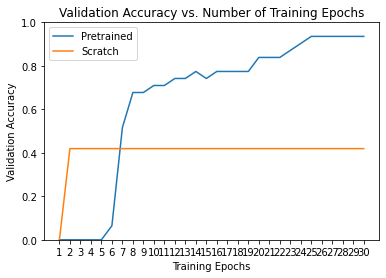

In [10]:
# Initialize the non-pretrained version of the model used for this run
feature_extract=False
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)

if set_optimizer == 'SGD':
    scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)       
elif set_optimizer == 'Adam':
    scratch_optimizer = optim.Adam(scratch_model.parameters(), lr=0.001, weight_decay=0.00001)
else:
    print("Invalid optimizer name, exiting...")
    exit()
    
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

## Model Evaluation with Confusion Matrix

In [11]:
test_image_path = data_dir + "/test/*"

In [12]:
def label_getter():
    class_label = []
    folders = glob.glob(data_dir + "/test/*")
    for folder in folders:
            label = os.path.basename(folder)
            class_label.append(label)
    
    return class_label

In [13]:
def model_setter(model_path):
    test_model = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)[0]
    test_model.load_state_dict(torch.load(model_path))
    test_model.eval()
    
    return test_model

In [14]:
def image_preprocessing(image_path):

    transform_test = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_read = cv2.imread(image_path)
    img = Image.fromarray(np.uint8(img_read))
    inputs = transform_test(img)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    inputs = inputs.unsqueeze(0).to(device)

    return inputs 

In [15]:
def label_setter(model,processed_image):

    labels = label_getter()
    labels.reverse()
    label = None
    num_classes = len(labels)
    
    result = model(processed_image)

    idx = torch.argmax(result[0])
    
    label = labels[int(idx)]

    return label

In [16]:
def True_Pred(model_path):
    folders = glob.glob(data_dir + "/test/*")
    model = model_setter(model_path)
    True_label = []
    Pred_label = []

    for folder in folders:

        files = glob.glob(folder + "/*")
        label = os.path.basename(folder)
        for file in files:
            True_label.append(label)
            Pred_label.append(label_setter(model, image_preprocessing(file)))
    
    return True_label,Pred_label

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

In [18]:
def show_confusionmatrix(path_model, name):
    true_label, predict_label = True_Pred(path_model)
    
    cnf_matrix = confusion_matrix(true_label, predict_label,labels=label_getter())
    np.set_printoptions(precision=1)
 
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=label_getter(),
                      title='Confusion matrix with ')
    

### Pretrained Model

#### Best val acc

In [19]:
PATH_model = data_dir[:18] + "/" + model_name + '_'+ set_optimizer + "_pretrained.pth"

Confusion matrix, without normalization
[[ 9  0  0]
 [ 0 10  0]
 [ 1  0 13]]


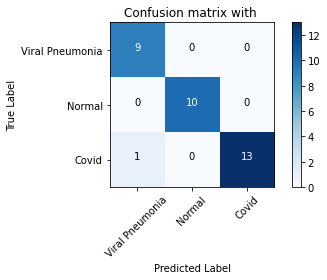

In [20]:
show_confusionmatrix(PATH_model, name="Pretrained at best val acc")

#### Last epoch

In [21]:
PATH_model = data_dir[:18]  + "/" + model_name + '_'+ set_optimizer + "_pretrained_lastEpoch.pth"

Confusion matrix, without normalization
[[ 9  0  0]
 [ 0 10  0]
 [ 1  0 13]]


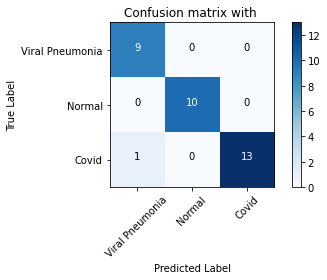

In [22]:
show_confusionmatrix(PATH_model, name="Pretrained at the last Epoch")

### Scratch Model

#### Best val acc

In [23]:
PATH_model = data_dir[:18] + "/" + model_name + '_'+ set_optimizer + "_scratch.pth"

Confusion matrix, without normalization
[[ 0  0  9]
 [ 0  0 10]
 [ 0  0 14]]


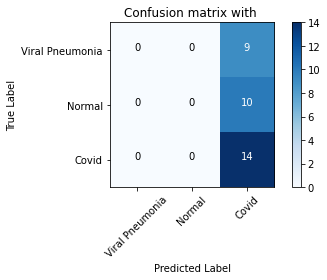

In [24]:
show_confusionmatrix(PATH_model, name="Scratch model at bese val acc")

#### Last epoch

In [25]:
PATH_model = data_dir[:18] + "/" + model_name + '_'+ set_optimizer + "_scratch_lastEpoch.pth"

Confusion matrix, without normalization
[[ 0  0  9]
 [ 0  0 10]
 [ 0  0 14]]


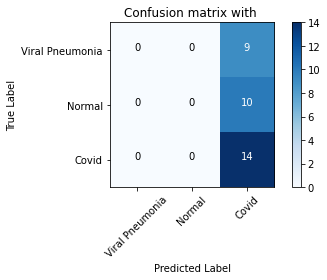

In [26]:
show_confusionmatrix(PATH_model, name="Scratch model at the last Epoch")